In [59]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Literal
from pydantic import BaseModel, Field
load_dotenv()
model=ChatOpenAI(model="gpt-4o-mini")


In [60]:
#structured output model for sentiment analysis
class StructuredOutput(BaseModel):
    sentiment:Literal["positive","negative"]=Field(description="Sentiment of the reviewed text")

structured_model=model.with_structured_output(StructuredOutput)


#structured output model for diagnosis Schema
class DiagnosisSchema(BaseModel):
    issue_type:Literal["UX","Performance","BUG","Support","other"]=Field(description="Type of issue identified in the review")
    tone:Literal["angry","happy","neutral","sad"]=Field(description="Tone of the review")
    urgency:Literal["high","medium","low"]=Field(description="Urgency level of the issue mentioned in the review")

structured_model_diagnosis=model.with_structured_output(DiagnosisSchema)


In [61]:
#define the state
class SentimentState(TypedDict):
    review_text: str
    sentiment: Literal["positive","negative"]
    diagnosis:dict
    response:str

In [62]:
def find_sentiment(state:SentimentState)->SentimentState:
    prompt=f'provide the sentiment for the given text:{state["review_text"]}'
    output=structured_model.invoke(prompt)
    return {"sentiment":output.sentiment}

def check_sentiment(state:SentimentState)->Literal['positive_response','run_diagnosis']:
    if state['sentiment']=='positive':
        return 'positive_response'
    elif state['sentiment']=='negative':
        return 'run_diagnosis'

def positive_response(state:SentimentState)->SentimentState:
    return {'response':'Thank you for your positive review! We appreciate your feedback.'}

def run_diagnosis(state:SentimentState)->SentimentState:
    prompt=f'Analyze and tell me the Return issue_type , tone and urgency for the :{state["review_text"]}'
    output=structured_model_diagnosis.invoke(prompt)
    return {'diagnosis':output.model_dump()} # to add to the dictionary

def negative_response(state:SentimentState)->SentimentState:
    diagnosis=state['diagnosis']
    prompt=f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded {diagnosis['tone']},
    and marked urgency as {diagnosis['urgency']}.
    Write an empathetic, helpful resolution message"""
    output=model.invoke(prompt)
    return {'response':output.content}

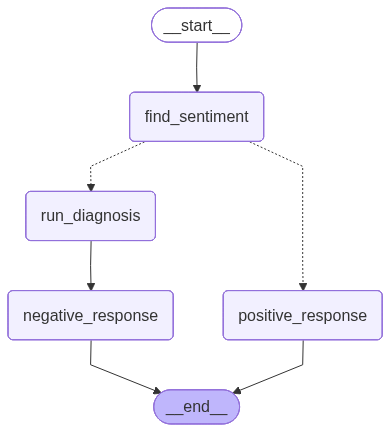

In [63]:
#define the nodes
graph=StateGraph(SentimentState)
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
               
#add edges
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)

graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)


graph.compile()


In [64]:
workflow=graph.compile()

test1= """I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial. Great job to the design team!!."""
test2= """This app is terrible. It crashes all the time and I've lost so much work because of it. The customer support is unhelpful and rude. I can't believe I wasted my money on this garbage. Do not download this app if you value your sanity."""
#test the workflow
initial_state={'review_text':test2}

final_state=workflow.invoke(initial_state)

print(f"Final State: {final_state}")
print(f"Response to User: {final_state['response']}")
print(f"Diagnosis: {final_state.get('diagnosis','N/A')}")
print(f"Sentiment: {final_state['sentiment']}")

Final State: {'review_text': "This app is terrible. It crashes all the time and I've lost so much work because of it. The customer support is unhelpful and rude. I can't believe I wasted my money on this garbage. Do not download this app if you value your sanity.", 'sentiment': 'negative', 'diagnosis': {'issue_type': 'BUG', 'tone': 'angry', 'urgency': 'high'}, 'response': "Subject: We're Here to Help with Your Issue\n\nHi [User's Name],\n\nI want to sincerely apologize for the frustration and inconvenience you've experienced with the bug. I understand how important this is to you, and I’m here to help resolve this as quickly as possible.\n\nCould you please provide a bit more detail about the issue you're facing? Any specific error messages or steps you took leading up to the problem would be very helpful. \n\nRest assured, I’m committed to getting this sorted out for you as soon as I can. Thank you for your patience, and I look forward to your reply.\n\nBest regards,\n\n[Your Name]  \